# Código del profe


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')  # Aplicar el estilo 'ggplot'


def inicializar_pesos(n_entrada, n_capa_2, n_capa_3):
    randomgen = np.random.default_rng()

    #w son los pesos, b son los sesgos. En este caso tenemos 2 capas luego de la capa de entrada
    
    #Se inicializan con un valor bajo. Por eso se multiplilcan por 0.1
    w1 = 0.1 * randomgen.standard_normal((n_entrada, n_capa_2))
    b1 = 0.1 * randomgen.standard_normal((1, n_capa_2))

    w2 = 0.1 * randomgen.standard_normal((n_capa_2, n_capa_3))
    b2 = 0.1 * randomgen.standard_normal((1,n_capa_3))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}


def ejecutar_adelante(x, pesos):
    # Funcion de entrada (a.k.a. "regla de propagacion") para la primera capa oculta
    z = x.dot(pesos["w1"]) + pesos["b1"]
    #Por más que b1 sea un vector y la multiplicación de x*w sea una matriz, como tienen la misma cantidad de columnas, se puede hacer la suma porque numpy intuye que queremos sumar a cada fila de la matriz el mismo vector b.

    # Funcion de activacion ReLU para la capa oculta (h -> "hidden")
    h = np.maximum(0, z)
    #Esta función de activación convierte a 0 los valores negativos, y deja como está a los valores positivos.

    # Salida de la red (funcion de activacion lineal). Esto incluye la salida de todas
    # las neuronas y para todos los ejemplos proporcionados
    y = h.dot(pesos["w2"]) + pesos["b2"]

    return {"z": z, "h": h, "y": y}



In [2]:
#recibe un vector, y devuelve un vector, pero aplicando la función sigmoide a cada elemento
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

Train

Modificado para poder resolver problemas de regresión


In [3]:
from sklearn.model_selection import train_test_split #para separar train de validacion
from sklearn.metrics import r2_score

# x: n entradas para cada uno de los m ejemplos(nxm)
# t: salida correcta (target) para cada uno de los m ejemplos (m x 1)
# pesos: pesos (W y b)
def train(x, t, pesos, learning_rate, epochs, funcion_activacion, NEURONAS):
    
    #Se hace K-fold cross validation. Esto implica correr 10 veces el entrenamiento para diferentes conjuntos de train y luego promediar el resultado.
    k_fold = 10

    punt_r2_val = [] #Guardo el puntaje del test de validacion en cada k_fold

    for j in range(k_fold):
        #print(f"k={j}")
        #Reinicio pesos
        pesos = inicializar_pesos(n_entrada=NEURONAS['entrada'], n_capa_2=NEURONAS['oculta'], n_capa_3=NEURONAS['salida'])

        #Separo train de validacion. La validación es el 10% del original. Train es el otro 90%.
        x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.1)

        # Cantidad de filas (i.e. cantidad entradas en train)
        m = np.size(x_train, 0)

        #Reinicio vector para parada temprana
        vect_paradaTemprana = []
        parada_temprana = False #flag para cortar por parada temprana

        for i in range(epochs):
            
            # Ejecucion de la red hacia adelante
            resultados_feed_forward = ejecutar_adelante(x_train, pesos)
            y = resultados_feed_forward["y"]
            h = resultados_feed_forward["h"]
            z = resultados_feed_forward["z"]

            #loss = (1 / m) * np.sum( np.square( t_train-y ))

            '''--- PARADA TEMPRANA ---'''
            if i % 100 == 0:
                vect_paradaTemprana, parada_temprana= analizar_parada_temprana(x_val,t_val, pesos, vect_paradaTemprana)

                if parada_temprana:
                    #print(f"k_fold {j}, Epoch {i}: parada_temprana")
                    break

            # Extraemos los pesos a variables locales
            w1 = pesos["w1"]
            b1 = pesos["b1"]
            w2 = pesos["w2"]
            b2 = pesos["b2"]

            '''--- EJERCICIO 5: MODIFICACION DE DERIVADAS ---'''
            # Ajustamos los pesos: Backpropagation

            dL_dy = 2/m*(y-t_train)

            dL_dw2 = h.T.dot(dL_dy)                         # Ajuste para w2
            dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)   # Ajuste para b2

            dL_dh = dL_dy.dot(w2.T)
            
            if funcion_activacion=='relu':
                dL_dz = dL_dh       # El calculo dL/dz = dL/dh * dh/dz. La funcion "h" es la funcion de activacion de la capa oculta,
                dL_dz[z <= 0] = 0   # para la que usamos ReLU. La derivada de la funcion ReLU: 1(z > 0) (0 en otro caso)
            
            elif funcion_activacion=='sigmoide':
                dL_dz = dL_dh*sigmoide(z)*(1-sigmoide(z))

            dL_dw1 = x_train.T.dot(dL_dz)                         # Ajuste para w1
            dL_db1 = np.sum(dL_dz, axis=0, keepdims=True)   # Ajuste para b1
            '''--- END EJERCICIO 5: MODIFICACION DE DERIVADAS ---'''

            # Aplicamos el ajuste a los pesos
            w1 += -learning_rate * dL_dw1
            b1 += -learning_rate * dL_db1
            w2 += -learning_rate * dL_dw2
            b2 += -learning_rate * dL_db2

            # Actualizamos la estructura de pesos
            # Extraemos los pesos a variables locales
            pesos["w1"] = w1
            pesos["b1"] = b1
            pesos["w2"] = w2
            pesos["b2"] = b2

        # Una vez entrenado, puntuo con el conjunto de validacion
        resultados_feed_forward = ejecutar_adelante(x_val, pesos)
        y = resultados_feed_forward["y"]
        r2 = r2_score(t_val,y)
        punt_r2_val.append(r2)
    
    #Devuelvo el vector completo de puntuaciones
    return punt_r2_val
        


Barrido hiperparámetros


In [4]:
import time

def barridoHiperparametros(numero_ejemplos, graficar_datos, dicc_hiperparametros, barrido):

    '''--- Creacion vectores ---'''
    #Extraigo los hiperparámetros del diccionario
    rango_learning_rate = dicc_hiperparametros["learning_rate"]
    min_lr= rango_learning_rate[0]
    max_lr= rango_learning_rate[1]
    paso_lr = rango_learning_rate[2]

    rango_cant_neuronas = dicc_hiperparametros["cant_neuronas"]
    min_cn= rango_cant_neuronas[0]
    max_cn= rango_cant_neuronas[1]
    paso_cn = rango_cant_neuronas[2]

    rango_epochs = dicc_hiperparametros["epochs"]
    min_e= rango_epochs[0]
    max_e= rango_epochs[1]
    paso_e = rango_epochs[2]

    funciones_activacion = dicc_hiperparametros["funciones_activacion"]
    funcion_relu=funciones_activacion[0]
    funcion_sigmoide=funciones_activacion[1]

    #Creo los vectores a analizar según el tipo de barrido
    if barrido=='matricial':
        vect_lr = np.arange(min_lr,
                            max_lr+paso_lr,
                            paso_lr)
        
        vect_cant_neuronas = np.arange(min_cn,
                                    max_cn+paso_cn,
                                    paso_cn)  
        
        vect_epochs = np.arange(min_e,
                                max_e+paso_e,
                                paso_e)

    elif barrido=='random':
        n = int ((max_lr-min_lr)/paso_lr)
        vect_lr = np.random.uniform(min_lr,
                                    max_lr,
                                    n)
        
        n = int ((max_cn-min_cn)/paso_cn)
        vect_cant_neuronas = np.random.uniform(min_cn,
                                            max_cn,
                                            n) 
        
        n = int ((max_e-min_e)/paso_e)
        vect_epochs = np.random.uniform(min_e,
                                        max_e,
                                        n)

    # Genero una matriz con todas las combinaciones posibles. Cada fila tiene una combinacion de elementos
    grid_v1, grid_v2, grid_v3 = np.meshgrid(vect_lr, vect_cant_neuronas, vect_epochs)
    matriz_combinatoria = np.stack((grid_v1.ravel(), grid_v2.ravel(), grid_v3.ravel()), axis=-1)
    
    cant_combinaciones = np.size(matriz_combinatoria, axis=0)

    print("Cantidad de combinaciones:", cant_combinaciones)

    '''--- GENERACION DE DATOS ---'''

    # Generamos datos
    x, t = generar_datos_regresion(numero_ejemplos)

    # Graficamos los datos si es necesario
    if graficar_datos:
        # Crear el gráfico de calor
        plt.scatter(x[:,0], x[:,1], c=t, cmap='coolwarm')
        plt.colorbar()

        # Personalizar el gráfico
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('Gráfico de Calor de t=f(x1,x2)')

        # Mostrar el gráfico
        plt.show()


    '''--- APLICACION DE BARRIDO ---'''
    NEURONAS_ENTRADA = 2
    NEURONAS_SALIDA = 1

    matriz_r2_relu = []
    matriz_r2_sigmoide = []

    contador = 0
    for vector in matriz_combinatoria:

        ti = time.time()

        learning_rate = vector[0]
        neuronas_capa_oculta = int(vector[1])
        epochs = int(vector[2])

        NEURONAS = {"entrada": NEURONAS_ENTRADA, "oculta": neuronas_capa_oculta, "salida": NEURONAS_SALIDA}
        
        # Entrenamiento con relu
        pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=neuronas_capa_oculta, n_capa_3=NEURONAS_SALIDA)
        vect_r2 = train(x, t, pesos, learning_rate, epochs, funcion_activacion=funcion_relu, NEURONAS=NEURONAS)
        matriz_r2_relu.append(vect_r2)

        # Entrenamiento con sigmoide
        pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=neuronas_capa_oculta, n_capa_3=NEURONAS_SALIDA)
        vect_r2 = train(x, t, pesos, learning_rate, epochs, funcion_activacion=funcion_relu, NEURONAS=NEURONAS)
        matriz_r2_sigmoide.append(vect_r2)

        tf = time.time()
        dt = tf-ti
        
        print(f"Combinacion {contador} analizada en {dt:0.2f} s")
        
        contador+=1


    '''--- ANALIZO RESULTADOS ---'''
    #Genero un vector, donde cada elemento es el promedio de los resultados obtenidos con k_fold
    promedios_r2_relu = np.mean(matriz_r2_relu, axis=1)
    promedios_r2_sigmoide = np.mean(matriz_r2_sigmoide, axis=1)

    #Obtengo el índice del máximo valor obtenido (para r^2 el modelo perfecto daría r^2=1)
    indice_mejor_relu = np.argmax(promedios_r2_relu)
    indice_mejor_sigmoide = np.argmax(promedios_r2_sigmoide)

    #Obtengo vector con los valores de r^2 de cada k_fold para los mejores parámetros
    mejor_vectorR2_relu = matriz_r2_relu[indice_mejor_relu]
    mejor_vectorR2_sigmoide = matriz_r2_sigmoide[indice_mejor_sigmoide]

    data = [mejor_vectorR2_relu, mejor_vectorR2_sigmoide]
    
    plt.boxplot(data)

    plt.xlabel('Función de activación')
    plt.ylabel('R^2')
    plt.title('Mejor combinación de hiperparámetros')

    plt.xticks([1, 2], ['Relu', 'Sigmoide'])

    plt.show()

    mejor_vectHip_relu = matriz_combinatoria[indice_mejor_relu]
    mejor_vectHip_sigmoide = matriz_combinatoria[indice_mejor_sigmoide]

    print("MEJORES HIPERPARÁMETROS RELU:")
    print(f"Learning rate: {mejor_vectHip_relu[0]} - Cant neuronas capa oculta: {mejor_vectHip_relu[1]} - Epochs: {mejor_vectHip_relu[2]}")
    
    print("MEJORES HIPERPARÁMETROS SIGMOIDE:")
    print(f"Learning rate: {mejor_vectHip_sigmoide[0]} - Cant neuronas capa oculta: {mejor_vectHip_sigmoide[1]} - Epochs: {mejor_vectHip_sigmoide[2]}")


# Ejercicio 3

Agregar parada temprana, utilizando un conjunto de validación, distinto del conjunto de
entrenamiento y de test (este punto requiere generar más ejemplos). Esto es: verificar el valor de
loss o de accuracy cada N epochs (donde N es un parámetro de configuración) utilizando el conjunto
de validación, y detener el entrenamiento en caso de que estos valores hayan empeorado (puede
incluirse una tolerancia para evitar cortar el entrenamiento por alguna oscilación propia del proceso
de entrenamiento).


In [5]:
'''LA PARADA TEMPRANA HA SIDO ACTUALIZADA PARA EL EJERCICIO 6'''


def analizar_parada_temprana(x_val, t_val, pesos, vect_paradaTemprana):
    #return vect_paradaTemprana, False
    tolerancia = 5

    resultados_feed_forward = ejecutar_adelante(x_val, pesos)
    y = resultados_feed_forward["y"]
    r2 = r2_score(t_val,y)

    vect_paradaTemprana.append(r2) #meto el nuevo r2

    #Primero verifico que haya la cantidad suficiente de componentes para comparar)
    if len(vect_paradaTemprana)<tolerancia:
        return vect_paradaTemprana, False #no se realiza parada temprana
    
    #Saco los últimos valores de vect_paradaTemprana para comparar, ojo, no tomo el último que acabo de meter
    ultimos = vect_paradaTemprana[-tolerancia:-1]

    for valor in ultimos:
        if r2>valor:
            #Quiere decir que el r2 mejora, no hay que realizar parada temprana
            return vect_paradaTemprana, False
    
    #Si se llega a este punto, es porque la precision no ha mejorado, por lo que se cumplen las condiciones para que haya parada temprana
    return vect_paradaTemprana, True

# Ejercicio 5

Modificar el programa para que funcione para resolver problemas de regresión

> a. Debe modificarse la función de pérdida y sus derivadas, utilizando por ejemplo MSE

> b. Debe crearse un generador de datos nuevo para que genere datos continuos (pueden
> mantenerse igualmente 2 entradas; en caso de usar más entradas puede requerirse más
> capas en la red neuronal)


In [6]:
'''Generador de datos continuos'''

def generar_datos_regresion(cantidad_ejemplos):
    # Generar datos de ejemplo
    n = cantidad_ejemplos
    x1 = np.random.uniform(0, 10, n)
    x2 = np.random.uniform(0, 10, n)
    x = np.c_[x1, x2]
    t = funcion_salida(x1, x2) 
    
    #La shape de t es (500,)
    # Agrego una nueva dimensión a t. Esto es para que coincida con la dimensión de y, que es (500,1)
    t = np.reshape(t, (cantidad_ejemplos,1))

    return x, t

def funcion_salida(x1, x2):
    # Definir una función para la relación entre x1, x2 y y
    t = np.sin(x1) + np.cos(x2)
    return t

In [7]:
from sklearn.metrics import r2_score

def r2_ej5(x,t,pesos,conjunto,imprimir=False):
    resultados_feed_forward = ejecutar_adelante(x, pesos)
    y = resultados_feed_forward["y"]
    r2 = r2_score(t,y)
    
    if imprimir:
        print("El r^2 de", conjunto, "es" ,r2)


# Ejercicio 6

Realizar un barrido de parámetros (learning rate, cantidad de neuronas en la capa oculta,
comparación de ReLU con Sigmoide)


In [11]:
#Estas serán los parámetros a analizar. Las listas tienen el siguiente orden:
#(valor_min, valor_max, paso)

rango_learning_rate = (0.01, 0.01, 0.01)

rango_cant_neuronas = (100, 100, 100)

rango_epochs = (30000, 30000, 5000)

funciones_activacion = ('relu', 'sigmoide')

#para pasarlos facil a la función los meto en un diccionario.
dicc_hiperparametros={"learning_rate": rango_learning_rate,
                 "cant_neuronas": rango_cant_neuronas,
                 "funciones_activacion": funciones_activacion,
                 "epochs": rango_epochs}

# Ejecucion


Cantidad de combinaciones: 1


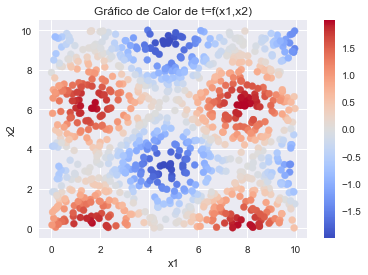

Combinacion 0 analizada en 158.15 s


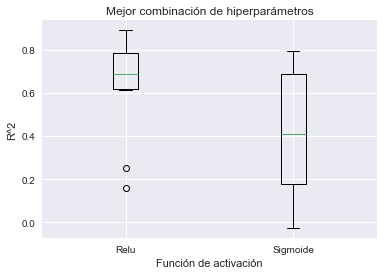

MEJORES HIPERPARÁMETROS RELU:
Learning rate: 0.01 - Cant neuronas capa oculta: 100.0 - Epochs: 30000.0
MEJORES HIPERPARÁMETROS SIGMOIDE:
Learning rate: 0.01 - Cant neuronas capa oculta: 100.0 - Epochs: 30000.0


In [12]:
barridoHiperparametros(numero_ejemplos=1000, graficar_datos=True, dicc_hiperparametros=dicc_hiperparametros, barrido='matricial')

Cantidad de combinaciones: 0


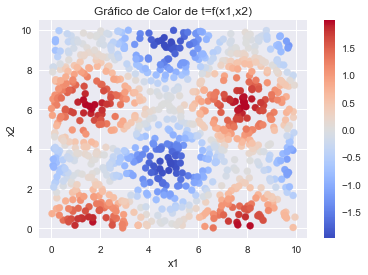

AxisError: axis 1 is out of bounds for array of dimension 1

In [10]:
barridoHiperparametros(numero_ejemplos=1000, graficar_datos=True, dicc_hiperparametros=dicc_hiperparametros, barrido='random')